In [76]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

df = pd.read_csv('data_imp.csv')
df = df[(df['nac_weight'].isna() == False) & (df['blade_weight'].isna() == False)]
df = df.drop(['Tower height (m)', 'Operator','Region_UK','Region_Asia','Region_US','Region_Europe','Region_Middle East'], axis=1)
max_values = df.max().values
min_values = df.min().values
range_values = max_values - min_values

train_data_length = 44
train_data = torch.zeros((train_data_length, len(df.columns)))
for i in range(train_data_length):
  vec = np.divide((df.iloc[i].values - min_values),range_values)
  # vec = vec.div_(torch.norm(vec,2))
  train_data[i, :] = torch.tensor(vec)
# train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
# train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
     (train_data[i], train_labels[i]) for i in range(train_data_length)
 ]

batch_size = 4
train_loader = torch.utils.data.DataLoader(
   train_set, batch_size=batch_size, shuffle=True
)

In [90]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

torch.manual_seed(112)

# train_data_length = 64
# train_data = torch.zeros((train_data_length, 2))
# train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
# train_data[:, 1] = torch.sin(train_data[:, 0])
# train_labels = torch.zeros(train_data_length)
# train_set = [
#     (train_data[i], train_labels[i]) for i in range(train_data_length)
# ]

# batch_size = 4
# train_loader = torch.utils.data.DataLoader(
#     train_set, batch_size=batch_size, shuffle=True
# )


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(len(df.columns), 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # false_indices = []
        # for i,entry in enumerate(x):
        #     if (entry.detach().numpy() > np.ones(entry.detach().shape)).any() == True:
        #         false_indices.append(i)
        #     if (entry.detach().numpy() < np.zeros(entry.detach().shape)).any() == True:
        #         false_indices.append(i)
        output = self.model(x)
        # helper = torch.ones(output.shape)
        # for i in false_indices:
        #     helper[i] = 0
        # output = output* helper
        
        return output
    
discriminator = Discriminator()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(len(df.columns), 12),
            nn.ReLU(),
            nn.Linear(12, len(df.columns)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

lr = 0.001
num_epochs = 2000
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, len(df.columns)))
        # latent_space_samples = torch.randn((batch_size, 2)))
        generated_samples = generator(latent_space_samples)
        
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, len(df.columns)))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)        
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.717871904373169
Epoch: 0 Loss G.: 0.5956761240959167
Epoch: 10 Loss D.: 0.6685046553611755
Epoch: 10 Loss G.: 0.7204183340072632
Epoch: 20 Loss D.: 0.6522254347801208
Epoch: 20 Loss G.: 0.7514634132385254
Epoch: 30 Loss D.: 0.6376795768737793
Epoch: 30 Loss G.: 0.7760848999023438
Epoch: 40 Loss D.: 0.592505156993866
Epoch: 40 Loss G.: 0.80811607837677
Epoch: 50 Loss D.: 0.5547165274620056
Epoch: 50 Loss G.: 0.7450395226478577
Epoch: 60 Loss D.: 0.5812593102455139
Epoch: 60 Loss G.: 0.7806736826896667
Epoch: 70 Loss D.: 0.5574871897697449
Epoch: 70 Loss G.: 0.7849447727203369
Epoch: 80 Loss D.: 0.5463106036186218
Epoch: 80 Loss G.: 0.7847930192947388
Epoch: 90 Loss D.: 0.49398601055145264
Epoch: 90 Loss G.: 1.0544259548187256
Epoch: 100 Loss D.: 0.5443088412284851
Epoch: 100 Loss G.: 0.8336419463157654
Epoch: 110 Loss D.: 0.5399280786514282
Epoch: 110 Loss G.: 0.765795111656189
Epoch: 120 Loss D.: 0.4745325446128845
Epoch: 120 Loss G.: 1.1122130155563354
Epoch: 130 L

In [ ]:
class Subdiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(len(df.columns), 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # false_indices = []
        # for i,entry in enumerate(x):
        #     if (entry.detach().numpy() > np.ones(entry.detach().shape)).any() == True:
        #         false_indices.append(i)
        #     if (entry.detach().numpy() < np.zeros(entry.detach().shape)).any() == True:
        #         false_indices.append(i)
        output = self.model(x)
        # helper = torch.ones(output.shape)
        # for i in false_indices:
        #     helper[i] = 0
        # output = output* helper
        
        return output
    
sub_discriminator = Subdiscriminator()

class subgenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(len(df.columns), 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

sub_generator = Subenerator()

lr = 0.001
num_epochs = 1000
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(sub_discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(sub_generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.zeros((batch_size, len(df.columns)))
        generated_samples = torch.zeros((batch_size, len(df.columns)))
        for i, real_sample in enumerate(real_samples):
            helper_tensor = torch.ones(real_sample.shape)
            helper_tensor[-2:] = torch.tensor([0,0])
            noise_tensor = torch.zeros(real_sample.shape)
            noise_tensor[-2:] = torch.randn((1, 2))
            latent_space_samples[i] = real_sample*helper_tensor + noise_tensor
            generated_samples[i] = real_sample*helper_tensor
        # latent_space_samples = torch.randn((batch_size, 2)))
        # generated_samples = generator(latent_space_samples)
        output_samples = sub_generator(latent_space_samples)
        generated_samples[:,len(df.columns)-2:] = output_samples
        
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        sub_discriminator.zero_grad()
        output_discriminator = sub_discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.zeros((batch_size, len(df.columns)))
        generated_samples = torch.zeros((batch_size, len(df.columns)))
        for i, real_sample in enumerate(real_samples):
            helper_tensor = torch.ones(real_sample.shape)
            helper_tensor[-2:] = torch.tensor([0,0])
            noise_tensor = torch.zeros(real_sample.shape)
            noise_tensor[-2:] = torch.randn((1, 2))
            latent_space_samples[i] = real_sample*helper_tensor + noise_tensor
            generated_samples[i] = real_sample*helper_tensor

        # Training the generator
        generator.zero_grad()
        output_samples = sub_generator(latent_space_samples)
        generated_samples[:,len(df.columns)-2:] = output_samples
        
        output_discriminator_generated = sub_discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.698615550994873
Epoch: 0 Loss G.: 0.5988715291023254
Epoch: 10 Loss D.: 0.6923916935920715
Epoch: 10 Loss G.: 0.7050164341926575
Epoch: 20 Loss D.: 0.6881301999092102
Epoch: 20 Loss G.: 0.7054848670959473
Epoch: 30 Loss D.: 0.6886031031608582
Epoch: 30 Loss G.: 0.7154160141944885
Epoch: 40 Loss D.: 0.6803545355796814
Epoch: 40 Loss G.: 0.7045958042144775
Epoch: 50 Loss D.: 0.638671875
Epoch: 50 Loss G.: 0.7102516889572144
Epoch: 60 Loss D.: 0.6388923525810242
Epoch: 60 Loss G.: 0.7475012540817261
Epoch: 70 Loss D.: 0.618256688117981
Epoch: 70 Loss G.: 0.8635425567626953
Epoch: 80 Loss D.: 0.7055367827415466
Epoch: 80 Loss G.: 0.7309904098510742
Epoch: 90 Loss D.: 0.7752848267555237
Epoch: 90 Loss G.: 0.8414660692214966
Epoch: 100 Loss D.: 0.6917474865913391
Epoch: 100 Loss G.: 0.7896829843521118
Epoch: 110 Loss D.: 0.6905792355537415
Epoch: 110 Loss G.: 0.6817298531532288
Epoch: 120 Loss D.: 0.727314293384552
Epoch: 120 Loss G.: 0.8552064895629883
Epoch: 130 Loss D.

In [68]:
discriminator(all_samples)

tensor([[0.6081],
        [0.4789],
        [0.7235],
        [0.5141],
        [0.4432],
        [0.3799],
        [0.3457],
        [0.2054]], grad_fn=<SigmoidBackward>)

In [ ]:

pd.DataFrame([np.multiply(all_samples[3].detach().numpy(), range_values) + min_values], columns = df.columns)

,a1,Turbine rating (kW),Blade length (m),Tower height (m),Built duration,Metocean,water_depth2,Type_Alpha,Type_beta,Type_delta,Type_gamma,nac_weight,blade_weight
0,150.000004,3000.000092,78.000001,233.999996,48.0,0.0,0.0,0.0,1.0,0.0,0.0,39.000001,0.0


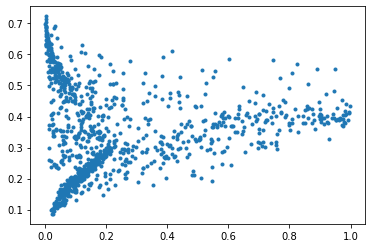

In [91]:
latent_space_samples = torch.randn(1000, len(df.columns))
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

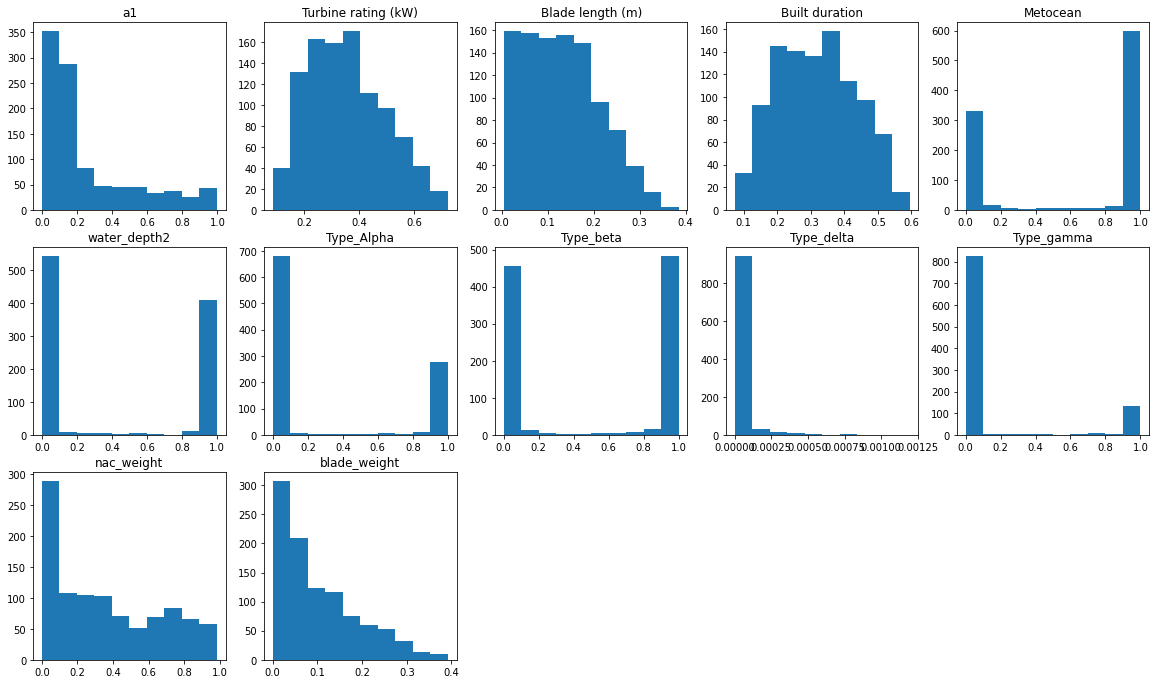

In [92]:
fig = plt.figure(figsize=(20,20))

for i in range(len(df.columns)):
  ax1 = fig.add_subplot(5,5,i+1)
  ax1.hist(generated_samples[:,i])
  ax1.set_title(df.columns[i])
# ax1 = fig.add_subplot(211)
# ax1.plot([(1, 2), (3, 4)], [(4, 3), (2, 3)])

# ax2 = fig.add_subplot(212)
# ax2.plot([(7, 2), (5, 3)], [(1, 6), (9, 5)])

plt.show()



In [93]:
ar = np.zeros(generated_samples.shape)
for i in range(len(generated_samples)):
  ar[i] = np.multiply(generated_samples[i,:].numpy(), range_values) + min_values

# generated_df = pd.DataFrame([sample], columns = df.columns)

In [94]:
generated_df = pd.DataFrame(ar, columns = df.columns)

In [95]:
generated_df.describe()

,a1,Turbine rating (kW),Blade length (m),Built duration,Metocean,water_depth2,Type_Alpha,Type_beta,Type_delta,Type_gamma,nac_weight,blade_weight
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,85.761822,2383.813549,18.486993,27.179445,6.312789e-01,8.675440e-01,3.028860e-01,5.153492e-01,2.487233e-05,1.548446e-01,49.001445,3.065993
std,57.762464,937.983767,7.620273,5.581297,4.654186e-01,9.691130e-01,4.488285e-01,4.873962e-01,9.172506e-05,3.487380e-01,36.868617,2.649218
min,30.206809,576.938570,6.441044,15.495943,5.457004e-14,1.725284e-16,2.846876e-31,1.822082e-29,4.126776e-21,0.000000e+00,5.046623,0.006452
25%,44.969131,1629.882284,12.097873,22.577660,7.816614e-04,1.230100e-06,4.186754e-13,3.050828e-08,1.914911e-11,2.953654e-22,13.752795,0.913320
50%,62.328082,2309.562939,17.727519,27.050628,9.996545e-01,2.035575e-02,3.745097e-07,7.945673e-01,1.350600e-08,9.180566e-14,41.272427,2.283848
75%,109.455841,3022.343438,23.644513,31.408222,1.000000e+00,2.000000e+00,9.928322e-01,1.000000e+00,2.133117e-06,8.362409e-05,82.280691,4.600259
max,249.366995,4844.461745,42.360309,40.531165,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.193505e-03,1.000000e+00,125.944665,11.754186


,a1,Turbine rating (kW),Blade length (m),Tower height (m),Built duration,Metocean,water_depth2,nac_weight,blade_weight
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,128.021277,1773.893617,49.324113,146.631915,35.241135,0.702128,0.914894,61.994043,14.541277
std,59.415080,1453.730931,22.438884,65.323897,9.451300,0.462267,0.951653,35.414602,7.300909
min,30.000000,0.000000,6.000000,18.000000,12.000000,0.000000,0.000000,5.000000,0.000000
25%,85.000000,825.000000,33.912500,101.737500,29.000000,0.000000,0.000000,31.000000,8.625000
50%,120.000000,1500.000000,45.000000,135.000000,34.666667,1.000000,1.000000,67.000000,16.000000
75%,152.000000,2160.000000,69.000000,206.000000,39.333333,1.000000,2.000000,92.000000,20.000000
max,250.000000,6700.000000,100.500000,285.000000,60.000000,1.000000,2.000000,128.000000,30.000000


In [ ]:
generated_df.to_csv('generated_data.csv', index=False)

In [ ]:
torch.save(discriminator.state_dict(), '/content/discriminator.pt')

In [ ]:
torch.save(generator.state_dict(), '/content/generator.pt')